In [1]:
!pip install spatialviewpy
!pip install scanorama
!pip install requests
!pip install igraph
!pip install leidenalg


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama

from spatialviewpy import prepare10xVisium_from_scanpy

from os import listdir, path
from collections import OrderedDict

from scipy.io import mmwrite, mmread
from zipfile import ZipFile
import requests
import os
import csv
import shutil
import json
import gzip

import warnings
warnings.filterwarnings('ignore')

In [2]:
#path to data directory
data_path = "../data"

sample_names = listdir(data_path)
sample_names = [d for d in sample_names if d[0] != '.']
sample_names = np.sort(sample_names)

sample_names
#sample_names = np.sort(sample_names[[0, 1]])
#sample_names

array(['MP2', 'MP33', 'MPH1', 'MPH2', 'Mky-194-10', 'Mky-194-8'],
      dtype='<U10')

In [4]:
samples_dict = OrderedDict()
for samp in sample_names:
    adata = sc.read_10x_h5(path.join(data_path, samp, 'filtered_feature_bc_matrix.h5'))
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["rp"] = adata.var_names.str.startswith("RP[SL]")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt","rp"], inplace=True)
    samples_dict[samp] = adata

In [ ]:
sample_info = pd.DataFrame(
    {
        'sample': [
            "MP2", "Mky-194-10", "MPH1", "MPH2", "MP33", "Mky-194-8"#, "MP7"#, "MP19", "MP31", "MP37", "Mky-2544", "Hu-A6", 
        ],
        'species': [
            "Rhesus", "Rhesus", "Human", "Human", "Rhesus", "Rhesus"#, "Rhesus"#, "Rhesus", "Rhesus", "Rhesus", "Rhesus", "Human"
        ],
        'group': [
            "ERaKD", "ERaKD", "Human", "Human", "Spontaneous", "ERaKD"#, "ERaKD"#, "ERaKD", "Spontaneous", "Spontaneous", "Spontaneous", "Human"
        ],
        'tissue': [
            "Omentum", "Ovary", "", "", "Fallopian Tube", "Fallopian Tube"#, "Ovary", "Colon", "Bladder Peritoneum", "Fallopian Tube", "Mesentery", ""
        ],
        'type': [
            "Endometriosis", "Tumor", "Endometriosis", "Endometriosis", "Endometriosis", "Endometriosis"#, "Endometriosis", "Endometriosis", "Endometriosis", "Endometriosis", "Endometriosis"
        ]
    }
)
sample_info = sample_info.sort_values(by = "sample")
sample_info = sample_info.reset_index(drop=True)
sample_info

,sample,species,group,tissue,type
0,MP2,Rhesus,ERaKD,Omentum,Endometriosis
1,MP33,Rhesus,Spontaneous,Bladder Peritoneum,Endometriosis
2,MPH1,Human,Human,,Endometriosis
3,MPH2,Human,Human,,Endometriosis
4,Mky-194-10,Rhesus,ERaKD,Ovary,Tumor


In [5]:
for name, adata in samples_dict.items():
    sc.pp.filter_cells(adata, min_counts=500)
    adata = adata[adata.obs["pct_counts_mt"] < 30]
    adata = adata[adata.obs["pct_counts_rp"] < 30]
    sc.pp.filter_genes(adata, min_cells=5)
    
    sc.pp.normalize_total(adata, target_sum = 10000, inplace=True, copy= True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)
    samples_dict[name] = adata

In [6]:
# We will use the unscaled normalized data for data visualization, thus saving them in a layer
adata_norm = sc.concat(
    list(samples_dict.values()),
    label="sample_id",
    uns_merge="unique",
    index_unique="_",
    keys = samples_dict.keys()
)


In [7]:
adatas_cor = scanorama.correct_scanpy(list(samples_dict.values()), 
                                      return_dimred=True,
                                     sigma = 10)

Found 10555 genes among all datasets
[[0.         0.5987055  0.         0.         0.12420607 0.00440141]
 [0.         0.         0.01218638 0.         0.07198306 0.08673835]
 [0.         0.         0.         0.51766685 0.00282287 0.        ]
 [0.         0.         0.         0.         0.00282287 0.        ]
 [0.         0.         0.         0.         0.         0.25758645]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (2, 3)
Processing datasets (4, 5)
Processing datasets (0, 4)


In [8]:
samples_dict.keys()

odict_keys([np.str_('MP2'), np.str_('MP33'), np.str_('MPH1'), np.str_('MPH2'), np.str_('Mky-194-10'), np.str_('Mky-194-8')])

In [9]:
adata_spatial = sc.concat(
    adatas_cor,
    label="sample_id",
    uns_merge="unique",
    index_unique="_",
    keys = samples_dict.keys()
)


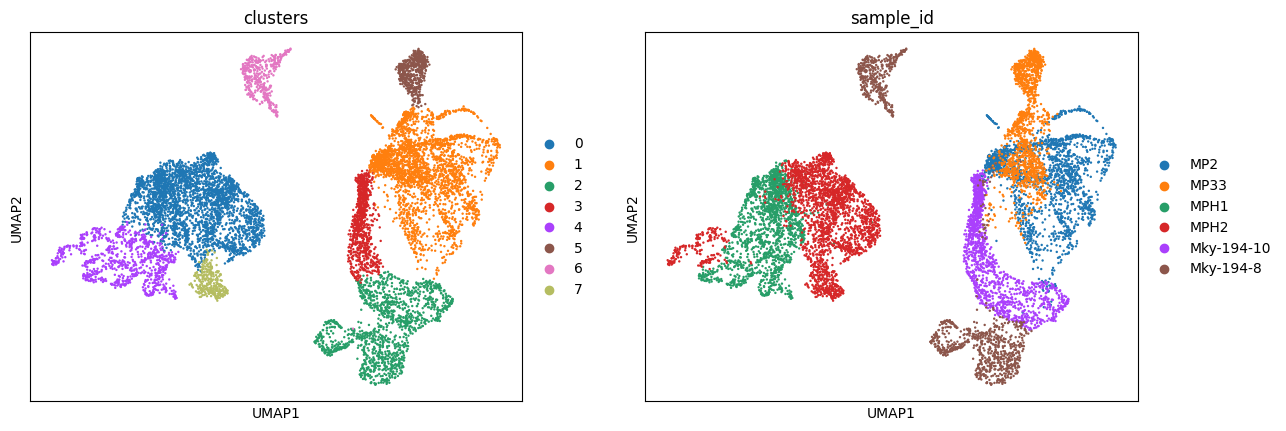

In [10]:
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial,resolution=0.15, key_added="clusters")

sc.pl.umap(
    adata_spatial, color=["clusters", "sample_id"], palette=sc.pl.palettes.default_20
)

In [11]:
adata_spatial.layers['normalized_counts'] = adata_norm.X

In [12]:
sc.tl.rank_genes_groups(adata_spatial, 'clusters', layer = 'normalized_counts',
                        method='wilcoxon', key_added = "de_genes",
                       n_genes = 30)

ranked_genes = adata_spatial.uns['de_genes']['names']
de_genes = [','.join(ranked_genes[c]) for c in ranked_genes.dtype.names]

In [13]:
sample_paths = [path.join(data_path, sample_name) for sample_name in sample_names]

prepare10xVisium_from_scanpy(adata_spatial, data_paths = sample_paths,
                       export_path = "TME",
                       cluster_genes = de_genes,
                       layer = 'normalized_counts',
                       download_repo = True,
                       launch_app = True,
                       port = 8878,
                       verbose= True,
                       sample_info = sample_info)

NameError: name 'sample_info' is not defined